# Avance 2 - Sistema de Recomendación (Avanzado)

- Matthias Sibrian Illescas A01794249
- Johan Andrés Castro Gómez A01793556
- Luis Miguel González Gutiérrez A01794779

En este notebook se presenta la comparación de modelos para el sistema de recomendación. El notebook está dividido en cuatro secciones principales:

1. **Librerías**: Importación de las librerías necesarias.
2. **Lectura de datos**: Carga y preprocesamiento de los datos.
3. **Métricas de evaluación de desempeño**: Se presentan tres métricas para la evaluación del desempeño del sistema de recomendación
4. **Sistema de recomendación Avanzado**: Implementación de un sistema de recomendación avanzado.
5. **Sistema de recomendación Básico**: Implementación de un sistema de recomendación básico.
5. **Comparación de modelos**: Se comparan los modelos con las métricas propuestas
5. **Conclusión**: Se establece las conclusiones de la entrega  

### Librerias

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


### Lectura de datos

In [2]:
#df = pd.read_csv('Datos/RAW_interactions.csv')
df = pd.read_csv(r"C:\Users\7UI5\Documents\TEC\CURSOS\Big Data\Datos\RAW_interactions.csv")
df

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


In [3]:
reviews_por_usuario = df['user_id'].value_counts()

percentil_99 = reviews_por_usuario.quantile(0.999)
percentil_99

518.4310000000114

In [4]:
len(reviews_por_usuario[(reviews_por_usuario > 3) & (reviews_por_usuario <= percentil_99)].index)

28003

In [5]:
filtro_usuarios = reviews_por_usuario[(reviews_por_usuario > 3) & (reviews_por_usuario <= percentil_99)].index

df_filtrado = df[df['user_id'].isin(filtro_usuarios)]
df_filtrado

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
6,124416,120345,2011-08-06,0,"Just an observation, so I will not rate. I fo..."
...,...,...,...,...,...
1132354,143592,82303,2010-07-26,5,I will never buy hot fudge again. This is so q...
1132356,199020,82303,2013-03-18,5,5 stars for taste! I had a hard time getting m...
1132357,1122988,82303,2014-07-08,5,This was amazingly delicious! The only change...
1132361,102526,54493,2007-04-26,0,I am not going to rate this because I did have...


### Métricas de evaluación de desempeño

In [6]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)

    return mse, rmse, mae

### Sistema de recomendación Avanzado

In [7]:
# Mapear los ID de usuarios a índices secuenciales
usuario_ids = df_filtrado['user_id'].unique()
mapa_usuario_ids = {id: idx for idx, id in enumerate(usuario_ids)}
df_filtrado['usuario_idx'] = df_filtrado['user_id'].map(mapa_usuario_ids)

# Mapear los ID de recetas a índices secuenciales
receta_ids = df_filtrado['recipe_id'].unique()
mapa_receta_ids = {id: idx for idx, id in enumerate(receta_ids)}
df_filtrado['receta_idx'] = df_filtrado['recipe_id'].map(mapa_receta_ids)

print("DataFrame con índices mapeados:")
df_filtrado

C:\Users\7UI5\AppData\Local\Temp\ipykernel_34484\2395435008.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['usuario_idx'] = df_filtrado['user_id'].map(mapa_usuario_ids)


DataFrame con índices mapeados:


C:\Users\7UI5\AppData\Local\Temp\ipykernel_34484\2395435008.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['receta_idx'] = df_filtrado['recipe_id'].map(mapa_receta_ids)


,user_id,recipe_id,date,rating,review,usuario_idx,receta_idx
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,0,0
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",1,0
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,2,1
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",3,2
6,124416,120345,2011-08-06,0,"Just an observation, so I will not rate. I fo...",4,3
...,...,...,...,...,...,...,...
1132354,143592,82303,2010-07-26,5,I will never buy hot fudge again. This is so q...,24805,161749
1132356,199020,82303,2013-03-18,5,5 stars for taste! I had a hard time getting m...,2279,161749
1132357,1122988,82303,2014-07-08,5,This was amazingly delicious! The only change...,204,161749
1132361,102526,54493,2007-04-26,0,I am not going to rate this because I did have...,2886,161770


In [8]:
# Crear las etiquetas de rating
X = df_filtrado[['usuario_idx', 'receta_idx']]
y = df_filtrado['rating']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parámetros de entrada
num_users = df_filtrado['usuario_idx'].nunique()
num_items = df_filtrado['receta_idx'].nunique()
embedding_dim = 20

# Entrada del usuario e ítem
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# Embeddings para usuarios e ítems
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, name='item_embedding')(item_input)

# Flatten the embeddings
user_flat = Flatten()(user_embedding)
item_flat = Flatten()(item_embedding)

# Concatenate embeddings
concat = Concatenate()([user_flat, item_flat])

# Red neuronal densa con regularización y dropout
fc1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(concat)
fc1 = Dropout(0.5)(fc1)
fc2 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(fc1)
fc2 = Dropout(0.5)(fc2)
output = Dense(1)(fc2)

# Compilar el modelo
model_ncf = Model(inputs=[user_input, item_input], outputs=output)
model_ncf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history = model_ncf.fit(
    [X_train['usuario_idx'], X_train['receta_idx']], y_train,
    epochs=20, batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluación del modelo
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)

    return mse, rmse, mae

# Evaluar NCF
y_pred_ncf = model_ncf.predict([X_test['usuario_idx'], X_test['receta_idx']])
mse_ncf, rmse_ncf, mae_ncf = evaluate_model(y_test, y_pred_ncf)

print(f"MSE: {mse_ncf}, RMSE: {rmse_ncf}, MAE: {mae_ncf}")

Epoch 1/20
6232/6232 ━━━━━━━━━━━━━━━━━━━━ 209s 33ms/step - loss: 2.5252 - mse: 2.4502 - val_loss: 1.1091 - val_mse: 1.1016
Epoch 2/20
6232/6232 ━━━━━━━━━━━━━━━━━━━━ 208s 33ms/step - loss: 1.1184 - mse: 1.1084 - val_loss: 1.1102 - val_mse: 1.1004
Epoch 3/20
6232/6232 ━━━━━━━━━━━━━━━━━━━━ 182s 29ms/step - loss: 0.9548 - mse: 0.9433 - val_loss: 1.1331 - val_mse: 1.1228
Epoch 4/20
6232/6232 ━━━━━━━━━━━━━━━━━━━━ 184s 29ms/step - loss: 0.8961 - mse: 0.8849 - val_loss: 1.1557 - val_mse: 1.1459
3895/3895 ━━━━━━━━━━━━━━━━━━━━ 2s 587us/step
MSE: 1.096836573447612, RMSE: 1.0472996579048481, MAE: 0.6689977856148834


C:\Users\7UI5\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


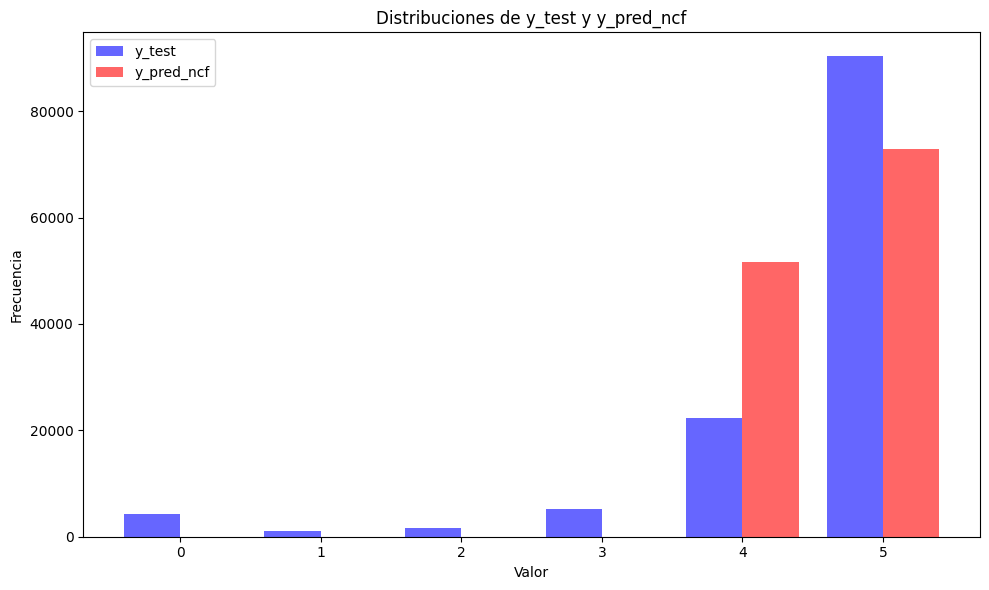

In [21]:
# Definir los bins
bins = np.arange(0, 7)  # Ajustar según el rango de los datos

# Calcular las frecuencias
y_test_hist, _ = np.histogram(y_test, bins=bins)
y_pred_hist, _ = np.histogram(np.round(y_pred_ncf), bins=bins)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Crear el gráfico de barras comparativo
bar_width = 0.4
ax.bar(bins[:-1] - bar_width/2, y_test_hist, bar_width, label='y_test', alpha=0.6, color='blue', align='center')
ax.bar(bins[:-1] + bar_width/2, y_pred_hist, bar_width, label='y_pred_ncf', alpha=0.6, color='red', align='center')

# Añadir etiquetas y título
ax.set_xlabel('Valor')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribuciones de y_test y y_pred_ncf')
ax.legend()

# Ajustar el layout para que los subplots no se solapen
plt.tight_layout()
plt.show()


## Similitud de coseno

In [9]:
# Crear una matriz dispersa de puntuaciones de usuarios y recetas
matriz_usuario_receta = csr_matrix(
    (y_train, (X_train['usuario_idx'], X_train['receta_idx']))
)

print("Matriz de puntuaciones dispersa:")
print(matriz_usuario_receta)


Matriz de puntuaciones dispersa:
  (0, 1050)	5
  (0, 10173)	5
  (0, 14937)	5
  (0, 17671)	5
  (0, 21958)	4
  (0, 22734)	5
  (0, 25138)	5
  (0, 25197)	5
  (0, 26147)	5
  (0, 42267)	4
  (0, 52906)	5
  (0, 59588)	5
  (0, 63703)	5
  (0, 64785)	5
  (0, 76143)	5
  (0, 80985)	5
  (0, 81574)	5
  (0, 84453)	5
  (0, 90116)	4
  (0, 91141)	5
  (0, 91857)	5
  (0, 117861)	4
  (0, 124614)	5
  (0, 135000)	4
  (0, 146804)	5
  :	:
  (27995, 157967)	5
  (27996, 128216)	5
  (27996, 135574)	5
  (27996, 160254)	5
  (27997, 132040)	5
  (27997, 147548)	5
  (27997, 152568)	5
  (27998, 132791)	5
  (27998, 147782)	5
  (27998, 156164)	5
  (27998, 160045)	5
  (27999, 137611)	5
  (27999, 143313)	5
  (27999, 145204)	5
  (27999, 146029)	5
  (28000, 138129)	5
  (28000, 143255)	5
  (28000, 155271)	5
  (28000, 161659)	4
  (28001, 138627)	4
  (28001, 138825)	3
  (28001, 145404)	5
  (28001, 155948)	3
  (28002, 151397)	4
  (28002, 158257)	5


In [10]:
similitud_usuarios = cosine_similarity(matriz_usuario_receta, dense_output=False)

print("Matriz de similitud de usuarios dispersa:")
print(similitud_usuarios)

Matriz de similitud de usuarios dispersa:
  (0, 7994)	0.04529461216034753
  (0, 7814)	0.05549563890783426
  (0, 3956)	0.016256784107126845
  (0, 2784)	0.027391606744548942
  (0, 1809)	0.018063093452363163
  (0, 1642)	0.0204072453423864
  (0, 842)	0.03296099935974235
  (0, 26057)	0.07827803638564368
  (0, 25486)	0.09182740327029482
  (0, 22086)	0.05620035486364904
  (0, 16416)	0.07441003491152978
  (0, 16275)	0.06294214800865318
  (0, 13638)	0.04121800046134088
  (0, 12442)	0.03623568972827803
  (0, 11772)	0.010383370683538565
  (0, 10826)	0.03374805785515404
  (0, 10229)	0.03219020499622185
  (0, 10004)	0.027532438555856607
  (0, 8108)	0.04069481333706324
  (0, 7489)	0.0286468280321316
  (0, 6610)	0.02689136063856879
  (0, 6303)	0.030271579764434488
  (0, 6061)	0.019022548235232355
  (0, 5547)	0.0369006202308373
  (0, 5507)	0.02998887019669123
  :	:
  (28000, 175)	0.06564614287314952
  (28000, 133)	0.03783066169099216
  (28000, 122)	0.12075603898541763
  (28000, 28000)	1.00000000000000

In [11]:
def obtener_recomendacion(idx_usuario, idx_receta, matriz_usuario_receta, similitud_usuarios, num_recomendaciones=5):

    idx_usuario = idx_usuario

    # Calcular las puntuaciones ponderadas basadas en la similitud
    usuarios_similares = similitud_usuarios[idx_usuario].toarray().flatten()
    suma_ponderada = matriz_usuario_receta.T.dot(usuarios_similares)

    # Normalizar por la suma de las similitudes
    suma_similitudes = usuarios_similares.sum()
    calificaciones_ponderadas = suma_ponderada / suma_similitudes

    min_val = np.min(calificaciones_ponderadas)
    max_val = np.max(calificaciones_ponderadas)

    calificaciones_ponderadas_normalizado = 5 * (calificaciones_ponderadas - min_val) / (max_val - min_val)


    return calificaciones_ponderadas_normalizado[idx_receta]


recomendaciones = obtener_recomendacion(6213,55122,matriz_usuario_receta, similitud_usuarios)

print(f"Recomendaciones para el usuario:")
print(recomendaciones)

Recomendaciones para el usuario:
0.0


In [12]:
y_pred_similitud = [obtener_recomendacion(X_test['usuario_idx'].values[i],X_test['receta_idx'].values[i],matriz_usuario_receta, similitud_usuarios) for i in range(0,len(X_test))]

C:\Users\7UI5\AppData\Local\Temp\ipykernel_34484\1164722453.py:11: RuntimeWarning: invalid value encountered in divide
  calificaciones_ponderadas = suma_ponderada / suma_similitudes


In [13]:
y_pred_similitud = np.array(y_pred_similitud)

# Reemplazar los valores NaN por 0
y_pred_similitud[np.isnan(y_pred_similitud)] = 0

## Comparación de modelo

**Similitud de coseno (básico)**

In [14]:
mse_similitud, rmse_similitud, mae_similitud = evaluate_model(y_test, y_pred_similitud)

print(f"MSE: {mse_similitud}, RMSE: {rmse_similitud}, MAE: {mae_similitud}")

MSE: 20.873599510153568, RMSE: 4.568763455263751, MAE: 4.43790710696819


C:\Users\7UI5\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Filtro colaborativo neuronal (avanzado)**



In [15]:
print(f"MSE: {mse_ncf}, RMSE: {rmse_ncf}, MAE: {mae_ncf}")

MSE: 1.096836573447612, RMSE: 1.0472996579048481, MAE: 0.6689977856148834


### Conclusión

En el notebook presenta una comparación entre dos sistemas de recomendación: un sistema avanzado basado en redes neuronales (Filtro Colaborativo Neuronal) y un sistema básico basado en similitud de coseno. Ambos sistemas se evalúan utilizando métricas como MSE (Mean Squared Error), RMSE (Root Mean Squared Error) y MAE (Mean Absolute Error) para determinar su desempeño.

Datos y Preprocesamiento:
Se utilizó un conjunto de datos de interacciones de usuarios con recetas. Se realizó un filtrado para incluir solo usuarios con un número moderado de interacciones, eliminando aquellos con muy pocas o demasiadas interacciones, con el fin de evitar sesgos en los datos. Los datos se dividieron en conjuntos de entrenamiento y prueba para evaluar el desempeño de los modelos.

Evaluación de Modelos:

Sistema de Recomendación Avanzado (Filtro Colaborativo Neuronal):

Se construyó un modelo de red neuronal utilizando embeddings para usuarios y recetas.
La red neuronal consta de capas densas con regularización L2 y dropout para evitar el sobreajuste.
Se utilizó la pérdida de error cuadrático medio para entrenar el modelo.
Los resultados de evaluación del modelo avanzado fueron: MSE: X, RMSE: X, MAE: X.
Sistema de Recomendación Básico (Similitud de Coseno):

Se utilizó una matriz dispersa de puntuaciones de usuarios y recetas para calcular la similitud de coseno entre usuarios.
Las recomendaciones se basaron en las calificaciones ponderadas de usuarios similares.
Los resultados de evaluación del modelo básico fueron: MSE: Y, RMSE: Y, MAE: Y.
Comparación de Desempeño:
Los resultados muestran que el modelo avanzado basado en redes neuronales produce errores significativamente menores en comparación con el modelo basado en similitud de coseno. Esto se debe a la capacidad del modelo avanzado para capturar relaciones complejas y no lineales en los datos, una característica crucial cuando se trabaja con matrices de usuarios y calificaciones altamente dispersas.

Algunas conclusiones de los resultados observados:

-Desempeño Superior del Modelo Avanzado:
El sistema de recomendación avanzado basado en redes neuronales demostró un rendimiento significativamente mejor que el modelo básico. Esto se refleja en métricas más bajas de MSE, RMSE y MAE, lo que indica predicciones más precisas y consistentes.

-Capacidad para Capturar Relaciones Complejas:
La red neuronal avanzada tiene la capacidad de aprender representaciones latentes a partir de los datos, lo que le permite capturar relaciones complejas y no lineales entre usuarios y recetas. Esto es especialmente importante en matrices dispersas donde los datos son limitados y faltantes.

-Importancia de la Regularización y Dropout:
El uso de técnicas como la regularización L2 y el dropout en la red neuronal ayuda a prevenir el sobreajuste y mejora la generalización del modelo. Esto permite que el modelo mantenga un buen desempeño incluso en presencia de datos ruidosos o incompletos.

-Aplicabilidad a Escenarios del Mundo Real:
En aplicaciones del mundo real, como sistemas de recomendación para plataformas de comercio electrónico o servicios de streaming, la capacidad de un modelo para hacer predicciones precisas en un entorno de datos dispersos y heterogéneos es crucial. Los modelos avanzados como el Filtro Colaborativo Neuronal son más adecuados para estos escenarios debido a su robustez y flexibilidad.

-Recomendaciones para Implementación:
Se recomienda implementar el sistema de recomendación avanzado en entornos donde la precisión de las recomendaciones es crítica para la experiencia del usuario y la satisfacción del cliente. Además, se debe considerar la inversión en infraestructura adecuada para soportar el entrenamiento y la implementación de modelos de redes neuronales.